In [17]:
import numpy as np
import matplotlib.pyplot as plt
import tkinter
import simpy
import random
import time 
import pandas as pd
import csv
import math

In [18]:
class Location:
    def __init__(self, name=None, distance=None):
        self.name = name
        self.distance = distance

In [19]:
class Call:
    id_call = 0 
    def __init__(self, ID=None, initial_time=None, final_time=None, status=None, location=None):
        Call.id_call = Call.id_call + 1
        self.ID = Call.id_call
        self.initial_time = initial_time
        self.final_time = final_time
        self.status = status 
        self.location = location
         
        
    def detail(self):
        print('Call from {} received at {}'.format(self.location.name, self.initial_time))
        
    def generate_Call(self, env, beta, distance, p, counter, boat_list, lastCall=None):
        self.location = Location()
        self.location.name = random.choices([*distance], p)[0]
        #self.location.distance = distance[' '.join(self.location.name)]
        self.location.distance = distance[self.location.name]

        if (lastCall==None):
            self.initial_time = float (np.random.exponential(scale=beta, size=1))
            yield env.timeout(self.initial_time)
        else:    
            self.initial_time = float (lastCall.initial_time + np.random.exponential(scale=beta, size=1))
            yield env.timeout(self.initial_time)

        print('%7.4f Call %d received from %s at a distance of %d' % (env.now, self.ID, self.location.name, self.location.distance))
        
        with counter.request() as req:
            yield req
            wait = env.now - self.initial_time #waiting time 
            #print('%7.4f Call %d: Waited %6.3f' % (env.now, self.ID, wait))
            yield env.process(trajet(env, boat_list, self, wait))
            #print('%7.4f Call %d: Finished' % (env.now, self.ID))

        self.status = 1
        

In [20]:
def trajet(env, boat_list, call, wait): 
    i = 0 
    while(i != len(boat_list) and boat_list[i].status != 0): #while you don't have a boat available 
        i = i + 1
    if(i != len(boat_list) and boat_list[i].status == 0): #if you have a boat available
        boat_list[i].status = 1 
        intervention = Intervention()
        #print('Boat {} with a speed of {} respond to the call {} '.format(boat_list[i].ID, boat_list[i].speed, call.ID))
        intervention.boat = boat_list[i]
        intervention.call = call
        intervention.travel_time = call.location.distance/boat_list[i].speed
        intervention.TOS = 0.25
        intervention.waited_time = wait 
        intervention.response_time = intervention.travel_time + wait 
        intervention.road_time = 2*intervention.travel_time + intervention.TOS 
        inter_list.append(intervention)
        yield env.timeout(intervention.road_time)
        call.final_time = call.initial_time + intervention.road_time 
        #print('Duration of the intervention {} : {} '.format(intervention.ID, intervention.road_time))
        boat_list[i].status = 0
    

In [21]:
class Intervention: 
    nb_inter = 0 
    def __init__(self, travel_time=None, TOS=None, response_time=None, road_time = None, waited_time=None, boat=None, call=None):
        Intervention.nb_inter = Intervention.nb_inter + 1 
        self.ID = Intervention.nb_inter
        self.travel_time = travel_time
        self.TOS = TOS
        self.response_time = response_time 
        self.road_time = road_time 
        self.waited_time = waited_time 
        self.boat = boat
        self.call = call
        
    def to_dict(self): 
        return {
            'ID intervention': self.ID,
            'Boat associated': self.boat.ID,
            'Call traited': self.call.ID,
            'Call location': self.call.location.name, 
            'travel time': self.travel_time,
            'Time On Scene': self.TOS,
            'response time': self.response_time,
            'waited time': self.waited_time,
            'total time': self.road_time, 
        }

In [22]:
class Boat: 
    nb_boat = 0 
    def __init__(self, env, speed=None, status=None): 
        Boat.nb_boat = Boat.nb_boat + 1 
        self.ID = Boat.nb_boat 
        self.speed = speed 
        self.status = status 

In [23]:
def source(env, counter, p, boat_list, call_list): 
    yield env.timeout(0)
    #print('%7.4f Start' % (env.now))
    for i in range(nb_call):
        call_list.append(Call())
        if i == 0: 
            env.process(call_list[i].generate_Call(env, 38, distance, p, counter, boat_list))
        else: 
            env.process(call_list[i].generate_Call(env, 38, distance, p, counter, boat_list, call_list[i-1]))

In [24]:
#Define the variables
p_2015 = [0.07246376812, 0.03623188406, 0.02898550725, 0.05797101449, 0.007246376812, 0.1086956522, 0.007246376812, 0.1449275362, 0.1231884058, 0.04347826087, 0.04347826087, 0.09420289855, 0.04347826087, 0.1231884058, 0.0652173913]
p_2016 = [0.04255319149, 0.01418439716, 0.007092198582, 0.07092198582, 0.04964539007, 0.09929078014, 0.01418439716, 0.06382978723, 0.09929078014, 0.09219858156, 0.134751773, 0.07092198582, 0.03546099291, 0.1843971631, 0.02127659574]
distance = {'N SRA CARMO':100, 'N SRA P. SOCORRO':90, 'BONSUCESSO':80, 'ASS. NAZARE':70, 'GUAJARA':60, 
            'ARUAU':100, 'MIPINDIAU':90, 'CUIEIRAS':75, 'SANTA MARIA':60, 'JARAQUI':52, 'COSTA DOS ARARAS':50, 
            'COSTA DO TATU':30, 'AGROVILA':20, 'N. SRA. FATIMA':15, 'LIVRAMENTO':15}
nb_boat = 4
nb_call = 164
nb_repet = 100
inter_list = []
df = []
call_list = []
interval = []
test = []

In [25]:
#Setup and lauch of the simulation 
def model():
    env = simpy.Environment()
    boat_list = []
    for i in range(nb_boat): 
        boat_list.append(Boat(env,46,0))
        #boat_list.append(Boat(env,30,0))
    counter = simpy.Resource(env, capacity=nb_boat)
    env.process(source(env, counter, p_2015, boat_list, call_list))
    env.run()

#Allow to launch nb_repet of repetitions 
for i in range(nb_repet): 
    model()
    df.append(pd.DataFrame.from_records([inter.to_dict() for inter in inter_list]))
    
    #allow to save the gaps between each call 
    gaps = [] 
    gaps.append(call_list[0].initial_time)
    for i in range (1,len(call_list)-1):
        gaps.append(call_list[i].initial_time-call_list[i-1].initial_time)
    mean_gaps = sum(gaps)/len(gaps)
    interval.append(mean_gaps)
    
    for inter in inter_list: 
        test.append(inter.road_time)
    
    #reset the global variables 
    inter_list = []
    call_list = []
    

32.2040 Call 1 received from SANTA MARIA at a distance of 60
32.3389 Call 2 received from ARUAU at a distance of 100
167.3797 Call 3 received from COSTA DO TATU at a distance of 30
257.5709 Call 4 received from CUIEIRAS at a distance of 75
261.1065 Call 5 received from ARUAU at a distance of 100
264.7307 Call 6 received from MIPINDIAU at a distance of 90
290.9742 Call 7 received from JARAQUI at a distance of 52
348.3701 Call 8 received from N SRA CARMO at a distance of 100
421.9712 Call 9 received from SANTA MARIA at a distance of 60
493.5545 Call 10 received from COSTA DO TATU at a distance of 30
509.2172 Call 11 received from CUIEIRAS at a distance of 75
529.7656 Call 12 received from N. SRA. FATIMA at a distance of 15
551.3738 Call 13 received from N SRA P. SOCORRO at a distance of 90
556.3576 Call 14 received from CUIEIRAS at a distance of 75
593.1607 Call 15 received from SANTA MARIA at a distance of 60
604.5857 Call 16 received from ASS. NAZARE at a distance of 70
669.9914 Call 1

 4.4109 Call 821 received from LIVRAMENTO at a distance of 15
29.3927 Call 822 received from N SRA P. SOCORRO at a distance of 90
56.3995 Call 823 received from SANTA MARIA at a distance of 60
62.8507 Call 824 received from BONSUCESSO at a distance of 80
90.6149 Call 825 received from N. SRA. FATIMA at a distance of 15
111.8506 Call 826 received from COSTA DO TATU at a distance of 30
235.7221 Call 827 received from ARUAU at a distance of 100
251.6942 Call 828 received from N. SRA. FATIMA at a distance of 15
271.9509 Call 829 received from SANTA MARIA at a distance of 60
279.7291 Call 830 received from ARUAU at a distance of 100
294.1158 Call 831 received from N. SRA. FATIMA at a distance of 15
335.5879 Call 832 received from COSTA DO TATU at a distance of 30
336.5884 Call 833 received from SANTA MARIA at a distance of 60
404.2242 Call 834 received from COSTA DO TATU at a distance of 30
426.2247 Call 835 received from N. SRA. FATIMA at a distance of 15
432.2178 Call 836 received from SA

242.4845 Call 1321 received from ARUAU at a distance of 100
244.5562 Call 1322 received from CUIEIRAS at a distance of 75
296.3604 Call 1323 received from COSTA DOS ARARAS at a distance of 50
305.5988 Call 1324 received from N SRA CARMO at a distance of 100
366.8081 Call 1325 received from N. SRA. FATIMA at a distance of 15
371.5686 Call 1326 received from COSTA DOS ARARAS at a distance of 50
428.3702 Call 1327 received from COSTA DO TATU at a distance of 30
449.5141 Call 1328 received from N. SRA. FATIMA at a distance of 15
469.8492 Call 1329 received from SANTA MARIA at a distance of 60
509.1360 Call 1330 received from COSTA DO TATU at a distance of 30
561.0013 Call 1331 received from ARUAU at a distance of 100
575.5557 Call 1332 received from LIVRAMENTO at a distance of 15
601.8024 Call 1333 received from N SRA CARMO at a distance of 100
673.7294 Call 1334 received from N SRA CARMO at a distance of 100
696.6748 Call 1335 received from COSTA DO TATU at a distance of 30
698.4939 Call 

632.9954 Call 1820 received from MIPINDIAU at a distance of 90
652.9989 Call 1821 received from N SRA CARMO at a distance of 100
653.0608 Call 1822 received from ARUAU at a distance of 100
710.8950 Call 1823 received from GUAJARA at a distance of 60
731.3444 Call 1824 received from ASS. NAZARE at a distance of 70
765.1641 Call 1825 received from LIVRAMENTO at a distance of 15
788.7310 Call 1826 received from LIVRAMENTO at a distance of 15
834.8412 Call 1827 received from AGROVILA at a distance of 20
836.1595 Call 1828 received from COSTA DOS ARARAS at a distance of 50
858.2637 Call 1829 received from N SRA P. SOCORRO at a distance of 90
905.5329 Call 1830 received from SANTA MARIA at a distance of 60
909.1219 Call 1831 received from N. SRA. FATIMA at a distance of 15
910.2784 Call 1832 received from LIVRAMENTO at a distance of 15
993.1036 Call 1833 received from COSTA DO TATU at a distance of 30
1000.4661 Call 1834 received from CUIEIRAS at a distance of 75
1003.1471 Call 1835 received

784.7125 Call 2320 received from SANTA MARIA at a distance of 60
901.8552 Call 2321 received from N SRA CARMO at a distance of 100
901.8872 Call 2322 received from ARUAU at a distance of 100
953.3166 Call 2323 received from SANTA MARIA at a distance of 60
955.5881 Call 2324 received from SANTA MARIA at a distance of 60
1026.3307 Call 2325 received from SANTA MARIA at a distance of 60
1048.3195 Call 2326 received from SANTA MARIA at a distance of 60
1073.8997 Call 2327 received from CUIEIRAS at a distance of 75
1076.5695 Call 2328 received from AGROVILA at a distance of 20
1181.1336 Call 2329 received from CUIEIRAS at a distance of 75
1249.4579 Call 2330 received from CUIEIRAS at a distance of 75
1265.1385 Call 2331 received from ASS. NAZARE at a distance of 70
1329.4498 Call 2332 received from SANTA MARIA at a distance of 60
1388.5408 Call 2333 received from N. SRA. FATIMA at a distance of 15
1440.3539 Call 2334 received from AGROVILA at a distance of 20
1604.2744 Call 2335 received fr

1949.0828 Call 2819 received from SANTA MARIA at a distance of 60
1952.1807 Call 2820 received from N SRA CARMO at a distance of 100
1960.3709 Call 2821 received from N SRA CARMO at a distance of 100
1978.6682 Call 2822 received from COSTA DO TATU at a distance of 30
2011.0716 Call 2823 received from COSTA DO TATU at a distance of 30
2029.4896 Call 2824 received from LIVRAMENTO at a distance of 15
2056.5000 Call 2825 received from N. SRA. FATIMA at a distance of 15
2063.9072 Call 2826 received from N. SRA. FATIMA at a distance of 15
2080.7996 Call 2827 received from N SRA CARMO at a distance of 100
2152.3429 Call 2828 received from JARAQUI at a distance of 52
2202.2002 Call 2829 received from ARUAU at a distance of 100
2348.5274 Call 2830 received from SANTA MARIA at a distance of 60
2434.4951 Call 2831 received from N SRA CARMO at a distance of 100
2457.0094 Call 2832 received from COSTA DO TATU at a distance of 30
2492.7389 Call 2833 received from N SRA CARMO at a distance of 100
253

 6.2286 Call 3445 received from SANTA MARIA at a distance of 60
79.5528 Call 3446 received from LIVRAMENTO at a distance of 15
81.7856 Call 3447 received from ASS. NAZARE at a distance of 70
113.6308 Call 3448 received from COSTA DOS ARARAS at a distance of 50
123.4726 Call 3449 received from LIVRAMENTO at a distance of 15
162.1727 Call 3450 received from MIPINDIAU at a distance of 90
170.4900 Call 3451 received from N. SRA. FATIMA at a distance of 15
171.2912 Call 3452 received from LIVRAMENTO at a distance of 15
210.9509 Call 3453 received from CUIEIRAS at a distance of 75
268.8103 Call 3454 received from N. SRA. FATIMA at a distance of 15
291.2663 Call 3455 received from N. SRA. FATIMA at a distance of 15
296.0085 Call 3456 received from AGROVILA at a distance of 20
316.9542 Call 3457 received from COSTA DOS ARARAS at a distance of 50
338.1202 Call 3458 received from CUIEIRAS at a distance of 75
390.9594 Call 3459 received from COSTA DO TATU at a distance of 30
597.1044 Call 3460 re

1600.3659 Call 3818 received from CUIEIRAS at a distance of 75
1600.6190 Call 3819 received from N. SRA. FATIMA at a distance of 15
1626.3273 Call 3820 received from SANTA MARIA at a distance of 60
1736.9500 Call 3821 received from N. SRA. FATIMA at a distance of 15
1799.4019 Call 3822 received from LIVRAMENTO at a distance of 15
1880.0247 Call 3823 received from JARAQUI at a distance of 52
1911.9574 Call 3824 received from ARUAU at a distance of 100
1927.3912 Call 3825 received from ARUAU at a distance of 100
1929.4198 Call 3826 received from N. SRA. FATIMA at a distance of 15
1963.5544 Call 3827 received from N SRA P. SOCORRO at a distance of 90
1987.9866 Call 3828 received from CUIEIRAS at a distance of 75
2001.2893 Call 3829 received from N SRA CARMO at a distance of 100
2006.4835 Call 3830 received from CUIEIRAS at a distance of 75
2007.9357 Call 3831 received from N SRA CARMO at a distance of 100
2034.0171 Call 3832 received from N SRA CARMO at a distance of 100
2092.4930 Call 38

2398.3209 Call 4318 received from COSTA DOS ARARAS at a distance of 50
2419.5218 Call 4319 received from COSTA DO TATU at a distance of 30
2471.8631 Call 4320 received from JARAQUI at a distance of 52
2486.9920 Call 4321 received from SANTA MARIA at a distance of 60
2501.5007 Call 4322 received from LIVRAMENTO at a distance of 15
2529.5201 Call 4323 received from SANTA MARIA at a distance of 60
2554.3312 Call 4324 received from LIVRAMENTO at a distance of 15
2643.1585 Call 4325 received from LIVRAMENTO at a distance of 15
2648.1293 Call 4326 received from CUIEIRAS at a distance of 75
2681.2478 Call 4327 received from N SRA P. SOCORRO at a distance of 90
2693.9369 Call 4328 received from COSTA DO TATU at a distance of 30
2716.8848 Call 4329 received from BONSUCESSO at a distance of 80
2734.6520 Call 4330 received from COSTA DO TATU at a distance of 30
2738.6660 Call 4331 received from JARAQUI at a distance of 52
2782.1122 Call 4332 received from SANTA MARIA at a distance of 60
2801.1967

2028.6011 Call 4817 received from JARAQUI at a distance of 52
2035.0106 Call 4818 received from N. SRA. FATIMA at a distance of 15
2110.9999 Call 4819 received from SANTA MARIA at a distance of 60
2134.1896 Call 4820 received from COSTA DO TATU at a distance of 30
2169.2581 Call 4821 received from COSTA DO TATU at a distance of 30
2236.5700 Call 4822 received from SANTA MARIA at a distance of 60
2293.1741 Call 4823 received from CUIEIRAS at a distance of 75
2296.0548 Call 4824 received from LIVRAMENTO at a distance of 15
2410.8814 Call 4825 received from AGROVILA at a distance of 20
2419.1501 Call 4826 received from N SRA P. SOCORRO at a distance of 90
2438.1962 Call 4827 received from LIVRAMENTO at a distance of 15
2448.7347 Call 4828 received from AGROVILA at a distance of 20
2454.9375 Call 4829 received from ASS. NAZARE at a distance of 70
2490.9331 Call 4830 received from ARUAU at a distance of 100
2493.6390 Call 4831 received from ASS. NAZARE at a distance of 70
2524.2533 Call 483

2934.1575 Call 5317 received from ARUAU at a distance of 100
2977.9181 Call 5318 received from SANTA MARIA at a distance of 60
3108.2030 Call 5319 received from AGROVILA at a distance of 20
3157.0441 Call 5320 received from ARUAU at a distance of 100
3164.6297 Call 5321 received from CUIEIRAS at a distance of 75
3190.9087 Call 5322 received from CUIEIRAS at a distance of 75
3208.1357 Call 5323 received from CUIEIRAS at a distance of 75
3254.4201 Call 5324 received from ASS. NAZARE at a distance of 70
3310.9926 Call 5325 received from CUIEIRAS at a distance of 75
3374.7807 Call 5326 received from ARUAU at a distance of 100
3379.3137 Call 5327 received from CUIEIRAS at a distance of 75
3393.0823 Call 5328 received from SANTA MARIA at a distance of 60
3423.8423 Call 5329 received from COSTA DO TATU at a distance of 30
3445.4062 Call 5330 received from COSTA DO TATU at a distance of 30
3446.3371 Call 5331 received from ARUAU at a distance of 100
3502.8387 Call 5332 received from CUIEIRAS a

2784.3476 Call 5816 received from CUIEIRAS at a distance of 75
2893.6696 Call 5817 received from SANTA MARIA at a distance of 60
2918.5484 Call 5818 received from AGROVILA at a distance of 20
2937.5882 Call 5819 received from CUIEIRAS at a distance of 75
2947.5086 Call 5820 received from N. SRA. FATIMA at a distance of 15
2952.8158 Call 5821 received from N. SRA. FATIMA at a distance of 15
3045.0116 Call 5822 received from BONSUCESSO at a distance of 80
3065.6622 Call 5823 received from COSTA DO TATU at a distance of 30
3070.6972 Call 5824 received from N SRA P. SOCORRO at a distance of 90
3115.5694 Call 5825 received from ASS. NAZARE at a distance of 70
3209.4623 Call 5826 received from N SRA P. SOCORRO at a distance of 90
3223.4952 Call 5827 received from SANTA MARIA at a distance of 60
3237.3470 Call 5828 received from JARAQUI at a distance of 52
3251.5889 Call 5829 received from N. SRA. FATIMA at a distance of 15
3251.9614 Call 5830 received from COSTA DO TATU at a distance of 30
3

48.6847 Call 6397 received from N. SRA. FATIMA at a distance of 15
96.4684 Call 6398 received from CUIEIRAS at a distance of 75
110.9326 Call 6399 received from COSTA DO TATU at a distance of 30
164.8771 Call 6400 received from JARAQUI at a distance of 52
203.1132 Call 6401 received from CUIEIRAS at a distance of 75
322.6690 Call 6402 received from LIVRAMENTO at a distance of 15
336.9627 Call 6403 received from N SRA CARMO at a distance of 100
395.1320 Call 6404 received from ARUAU at a distance of 100
467.0486 Call 6405 received from SANTA MARIA at a distance of 60
504.9848 Call 6406 received from N SRA CARMO at a distance of 100
549.0136 Call 6407 received from N. SRA. FATIMA at a distance of 15
616.1634 Call 6408 received from MIPINDIAU at a distance of 90
621.2084 Call 6409 received from N SRA P. SOCORRO at a distance of 90
706.6720 Call 6410 received from CUIEIRAS at a distance of 75
712.3939 Call 6411 received from ASS. NAZARE at a distance of 70
890.7794 Call 6412 received from 

20.0895 Call 7053 received from COSTA DO TATU at a distance of 30
22.9947 Call 7054 received from LIVRAMENTO at a distance of 15
25.5822 Call 7055 received from CUIEIRAS at a distance of 75
71.9839 Call 7056 received from ARUAU at a distance of 100
159.3680 Call 7057 received from CUIEIRAS at a distance of 75
227.0853 Call 7058 received from COSTA DO TATU at a distance of 30
310.4980 Call 7059 received from CUIEIRAS at a distance of 75
315.0601 Call 7060 received from COSTA DO TATU at a distance of 30
370.7418 Call 7061 received from JARAQUI at a distance of 52
440.5114 Call 7062 received from N. SRA. FATIMA at a distance of 15
471.1615 Call 7063 received from N. SRA. FATIMA at a distance of 15
507.1149 Call 7064 received from LIVRAMENTO at a distance of 15
534.3503 Call 7065 received from ARUAU at a distance of 100
559.3342 Call 7066 received from LIVRAMENTO at a distance of 15
634.4115 Call 7067 received from ARUAU at a distance of 100
663.2488 Call 7068 received from JARAQUI at a di

3605.2025 Call 7315 received from CUIEIRAS at a distance of 75
3624.5962 Call 7316 received from CUIEIRAS at a distance of 75
3698.1416 Call 7317 received from AGROVILA at a distance of 20
3781.4673 Call 7318 received from N SRA CARMO at a distance of 100
3852.0881 Call 7319 received from COSTA DOS ARARAS at a distance of 50
3854.7616 Call 7320 received from ASS. NAZARE at a distance of 70
3890.5484 Call 7321 received from N. SRA. FATIMA at a distance of 15
3912.7098 Call 7322 received from SANTA MARIA at a distance of 60
3962.0487 Call 7323 received from CUIEIRAS at a distance of 75
3977.7184 Call 7324 received from N. SRA. FATIMA at a distance of 15
3989.5412 Call 7325 received from SANTA MARIA at a distance of 60
4000.3616 Call 7326 received from COSTA DO TATU at a distance of 30
4019.6406 Call 7327 received from ARUAU at a distance of 100
4073.1568 Call 7328 received from ASS. NAZARE at a distance of 70
4181.4708 Call 7329 received from BONSUCESSO at a distance of 80
4210.4858 Call

4160.6711 Call 7814 received from ASS. NAZARE at a distance of 70
4166.9184 Call 7815 received from COSTA DO TATU at a distance of 30
4221.0213 Call 7816 received from JARAQUI at a distance of 52
4230.2103 Call 7817 received from ASS. NAZARE at a distance of 70
4249.7286 Call 7818 received from SANTA MARIA at a distance of 60
4315.0822 Call 7819 received from CUIEIRAS at a distance of 75
4439.2247 Call 7820 received from N SRA CARMO at a distance of 100
4442.4046 Call 7821 received from N. SRA. FATIMA at a distance of 15
4482.6576 Call 7822 received from CUIEIRAS at a distance of 75
4538.2509 Call 7823 received from CUIEIRAS at a distance of 75
4570.2592 Call 7824 received from N. SRA. FATIMA at a distance of 15
4618.6201 Call 7825 received from SANTA MARIA at a distance of 60
4656.0281 Call 7826 received from COSTA DO TATU at a distance of 30
4660.2686 Call 7827 received from N. SRA. FATIMA at a distance of 15
4700.6882 Call 7828 received from LIVRAMENTO at a distance of 15
4739.2771 

4405.0483 Call 8314 received from LIVRAMENTO at a distance of 15
4474.4152 Call 8315 received from N. SRA. FATIMA at a distance of 15
4487.7982 Call 8316 received from N. SRA. FATIMA at a distance of 15
4494.9033 Call 8317 received from N SRA P. SOCORRO at a distance of 90
4496.9435 Call 8318 received from N. SRA. FATIMA at a distance of 15
4533.6956 Call 8319 received from ASS. NAZARE at a distance of 70
4578.6593 Call 8320 received from GUAJARA at a distance of 60
4643.0396 Call 8321 received from SANTA MARIA at a distance of 60
4654.5146 Call 8322 received from ASS. NAZARE at a distance of 70
4659.3208 Call 8323 received from SANTA MARIA at a distance of 60
4674.7512 Call 8324 received from AGROVILA at a distance of 20
4682.1560 Call 8325 received from ASS. NAZARE at a distance of 70
4742.7741 Call 8326 received from AGROVILA at a distance of 20
4752.0499 Call 8327 received from BONSUCESSO at a distance of 80
4827.9832 Call 8328 received from N. SRA. FATIMA at a distance of 15
4829.

4271.6148 Call 8813 received from ARUAU at a distance of 100
4284.7147 Call 8814 received from SANTA MARIA at a distance of 60
4297.4193 Call 8815 received from ASS. NAZARE at a distance of 70
4310.3761 Call 8816 received from CUIEIRAS at a distance of 75
4325.6181 Call 8817 received from CUIEIRAS at a distance of 75
4326.5574 Call 8818 received from LIVRAMENTO at a distance of 15
4367.9988 Call 8819 received from SANTA MARIA at a distance of 60
4446.4078 Call 8820 received from SANTA MARIA at a distance of 60
4554.2199 Call 8821 received from GUAJARA at a distance of 60
4578.2791 Call 8822 received from N. SRA. FATIMA at a distance of 15
4589.6880 Call 8823 received from CUIEIRAS at a distance of 75
4646.8493 Call 8824 received from LIVRAMENTO at a distance of 15
4823.4825 Call 8825 received from JARAQUI at a distance of 52
4838.5506 Call 8826 received from CUIEIRAS at a distance of 75
4841.6026 Call 8827 received from CUIEIRAS at a distance of 75
4866.8592 Call 8828 received from LIV

4487.0375 Call 9313 received from ARUAU at a distance of 100
4536.4927 Call 9314 received from ASS. NAZARE at a distance of 70
4537.4005 Call 9315 received from GUAJARA at a distance of 60
4626.8487 Call 9316 received from ASS. NAZARE at a distance of 70
4697.8676 Call 9317 received from AGROVILA at a distance of 20
4751.5704 Call 9318 received from LIVRAMENTO at a distance of 15
4787.5292 Call 9319 received from N. SRA. FATIMA at a distance of 15
4812.3183 Call 9320 received from ARUAU at a distance of 100
4836.9529 Call 9321 received from N SRA CARMO at a distance of 100
4857.0264 Call 9322 received from N SRA P. SOCORRO at a distance of 90
4888.0634 Call 9323 received from N SRA CARMO at a distance of 100
4950.5347 Call 9324 received from COSTA DOS ARARAS at a distance of 50
4968.4289 Call 9325 received from BONSUCESSO at a distance of 80
4986.6050 Call 9326 received from N. SRA. FATIMA at a distance of 15
4993.2174 Call 9327 received from N SRA P. SOCORRO at a distance of 90
5017.4

3365.2355 Call 9927 received from N SRA CARMO at a distance of 100
3371.2032 Call 9928 received from N. SRA. FATIMA at a distance of 15
3371.3949 Call 9929 received from CUIEIRAS at a distance of 75
3441.0031 Call 9930 received from ARUAU at a distance of 100
3442.8069 Call 9931 received from COSTA DO TATU at a distance of 30
3464.0990 Call 9932 received from SANTA MARIA at a distance of 60
3505.5106 Call 9933 received from N. SRA. FATIMA at a distance of 15
3513.3815 Call 9934 received from N SRA CARMO at a distance of 100
3553.8218 Call 9935 received from COSTA DO TATU at a distance of 30
3631.1240 Call 9936 received from N SRA CARMO at a distance of 100
3636.7913 Call 9937 received from SANTA MARIA at a distance of 60
3774.2633 Call 9938 received from JARAQUI at a distance of 52
3839.9668 Call 9939 received from N SRA CARMO at a distance of 100
3841.2921 Call 9940 received from ARUAU at a distance of 100
3873.4340 Call 9941 received from CUIEIRAS at a distance of 75
3883.7007 Call 9

6417.9421 Call 10312 received from SANTA MARIA at a distance of 60
6421.9152 Call 10313 received from N. SRA. FATIMA at a distance of 15
6432.2481 Call 10314 received from ARUAU at a distance of 100
6478.9594 Call 10315 received from COSTA DO TATU at a distance of 30
6506.9275 Call 10316 received from N. SRA. FATIMA at a distance of 15
6515.4914 Call 10317 received from ASS. NAZARE at a distance of 70
6558.5624 Call 10318 received from N. SRA. FATIMA at a distance of 15
6715.4743 Call 10319 received from CUIEIRAS at a distance of 75
6748.4481 Call 10320 received from AGROVILA at a distance of 20
6931.6373 Call 10321 received from BONSUCESSO at a distance of 80
6941.4012 Call 10322 received from COSTA DOS ARARAS at a distance of 50
6949.9013 Call 10323 received from CUIEIRAS at a distance of 75
7050.5424 Call 10324 received from N SRA P. SOCORRO at a distance of 90
7188.4897 Call 10325 received from N SRA P. SOCORRO at a distance of 90
7273.5070 Call 10326 received from COSTA DO TATU at

4888.5286 Call 10811 received from AGROVILA at a distance of 20
4890.3106 Call 10812 received from SANTA MARIA at a distance of 60
4894.8546 Call 10813 received from LIVRAMENTO at a distance of 15
4896.4181 Call 10814 received from N SRA CARMO at a distance of 100
4916.9042 Call 10815 received from SANTA MARIA at a distance of 60
4926.5724 Call 10816 received from N SRA CARMO at a distance of 100
4949.6853 Call 10817 received from ASS. NAZARE at a distance of 70
5008.4939 Call 10818 received from N SRA P. SOCORRO at a distance of 90
5019.4831 Call 10819 received from SANTA MARIA at a distance of 60
5039.4103 Call 10820 received from CUIEIRAS at a distance of 75
5101.2728 Call 10821 received from SANTA MARIA at a distance of 60
5104.3535 Call 10822 received from SANTA MARIA at a distance of 60
5106.9353 Call 10823 received from N SRA CARMO at a distance of 100
5142.7738 Call 10824 received from N. SRA. FATIMA at a distance of 15
105.8856 Call 10825 received from ASS. NAZARE at a distanc

2913.5852 Call 11551 received from N SRA P. SOCORRO at a distance of 90
2934.9686 Call 11552 received from N. SRA. FATIMA at a distance of 15
2975.2763 Call 11553 received from SANTA MARIA at a distance of 60
2978.1046 Call 11554 received from ARUAU at a distance of 100
2993.8512 Call 11555 received from CUIEIRAS at a distance of 75
3034.1847 Call 11556 received from LIVRAMENTO at a distance of 15
3082.2408 Call 11557 received from SANTA MARIA at a distance of 60
3240.6775 Call 11558 received from ASS. NAZARE at a distance of 70
3274.8891 Call 11559 received from CUIEIRAS at a distance of 75
3365.9294 Call 11560 received from SANTA MARIA at a distance of 60
3393.8934 Call 11561 received from N. SRA. FATIMA at a distance of 15
3401.7461 Call 11562 received from ARUAU at a distance of 100
3440.3364 Call 11563 received from N SRA CARMO at a distance of 100
3487.7585 Call 11564 received from ARUAU at a distance of 100
3504.6860 Call 11565 received from N SRA CARMO at a distance of 100
3547

29.9709 Call 11810 received from ARUAU at a distance of 100
31.8853 Call 11811 received from LIVRAMENTO at a distance of 15
36.5266 Call 11812 received from CUIEIRAS at a distance of 75
38.2746 Call 11813 received from N. SRA. FATIMA at a distance of 15
38.7615 Call 11814 received from CUIEIRAS at a distance of 75
77.7335 Call 11815 received from N SRA P. SOCORRO at a distance of 90
119.6025 Call 11816 received from CUIEIRAS at a distance of 75
140.8961 Call 11817 received from LIVRAMENTO at a distance of 15
160.6517 Call 11818 received from CUIEIRAS at a distance of 75
266.8734 Call 11819 received from LIVRAMENTO at a distance of 15
291.0000 Call 11820 received from COSTA DO TATU at a distance of 30
298.4867 Call 11821 received from N SRA P. SOCORRO at a distance of 90
321.5753 Call 11822 received from ARUAU at a distance of 100
351.8397 Call 11823 received from SANTA MARIA at a distance of 60
395.6715 Call 11824 received from N SRA CARMO at a distance of 100
417.7364 Call 11825 recei

386.2575 Call 12310 received from ASS. NAZARE at a distance of 70
386.7056 Call 12311 received from N. SRA. FATIMA at a distance of 15
423.5741 Call 12312 received from ASS. NAZARE at a distance of 70
468.7458 Call 12313 received from ASS. NAZARE at a distance of 70
521.2092 Call 12314 received from JARAQUI at a distance of 52
533.5081 Call 12315 received from AGROVILA at a distance of 20
534.7281 Call 12316 received from ARUAU at a distance of 100
542.4673 Call 12317 received from SANTA MARIA at a distance of 60
603.8508 Call 12318 received from N. SRA. FATIMA at a distance of 15
615.3248 Call 12319 received from MIPINDIAU at a distance of 90
648.5191 Call 12320 received from COSTA DO TATU at a distance of 30
656.1327 Call 12321 received from JARAQUI at a distance of 52
686.4064 Call 12322 received from N SRA CARMO at a distance of 100
714.2845 Call 12323 received from BONSUCESSO at a distance of 80
719.3119 Call 12324 received from CUIEIRAS at a distance of 75
770.5180 Call 12325 rec

611.0607 Call 12809 received from N. SRA. FATIMA at a distance of 15
704.4674 Call 12810 received from ARUAU at a distance of 100
708.2459 Call 12811 received from SANTA MARIA at a distance of 60
749.4981 Call 12812 received from AGROVILA at a distance of 20
806.9706 Call 12813 received from MIPINDIAU at a distance of 90
807.3506 Call 12814 received from ASS. NAZARE at a distance of 70
845.2659 Call 12815 received from N SRA P. SOCORRO at a distance of 90
850.2102 Call 12816 received from BONSUCESSO at a distance of 80
882.4695 Call 12817 received from ASS. NAZARE at a distance of 70
954.6223 Call 12818 received from N SRA CARMO at a distance of 100
1007.2853 Call 12819 received from SANTA MARIA at a distance of 60
1035.9999 Call 12820 received from CUIEIRAS at a distance of 75
1056.9666 Call 12821 received from ASS. NAZARE at a distance of 70
1103.5443 Call 12822 received from COSTA DO TATU at a distance of 30
1105.5007 Call 12823 received from N. SRA. FATIMA at a distance of 15
1107.

841.6202 Call 13309 received from N SRA CARMO at a distance of 100
872.3140 Call 13310 received from AGROVILA at a distance of 20
887.1324 Call 13311 received from CUIEIRAS at a distance of 75
974.6342 Call 13312 received from N. SRA. FATIMA at a distance of 15
1118.3628 Call 13313 received from SANTA MARIA at a distance of 60
1199.9878 Call 13314 received from CUIEIRAS at a distance of 75
1256.2386 Call 13315 received from AGROVILA at a distance of 20
1258.5069 Call 13316 received from COSTA DO TATU at a distance of 30
1263.3430 Call 13317 received from BONSUCESSO at a distance of 80
1302.4941 Call 13318 received from ASS. NAZARE at a distance of 70
1377.9455 Call 13319 received from SANTA MARIA at a distance of 60
1380.5936 Call 13320 received from N SRA CARMO at a distance of 100
1577.0326 Call 13321 received from COSTA DO TATU at a distance of 30
1744.1165 Call 13322 received from CUIEIRAS at a distance of 75
1875.6668 Call 13323 received from SANTA MARIA at a distance of 60
1947.9

1207.7886 Call 13808 received from N SRA CARMO at a distance of 100
1233.5359 Call 13809 received from N. SRA. FATIMA at a distance of 15
1252.3534 Call 13810 received from ARUAU at a distance of 100
1256.6869 Call 13811 received from CUIEIRAS at a distance of 75
1297.4575 Call 13812 received from COSTA DOS ARARAS at a distance of 50
1309.0621 Call 13813 received from N SRA CARMO at a distance of 100
1363.2064 Call 13814 received from MIPINDIAU at a distance of 90
1378.1842 Call 13815 received from ARUAU at a distance of 100
1398.3829 Call 13816 received from CUIEIRAS at a distance of 75
1402.5397 Call 13817 received from LIVRAMENTO at a distance of 15
1450.1474 Call 13818 received from ARUAU at a distance of 100
1467.3937 Call 13819 received from SANTA MARIA at a distance of 60
1517.5900 Call 13820 received from SANTA MARIA at a distance of 60
1532.2700 Call 13821 received from LIVRAMENTO at a distance of 15
1553.8658 Call 13822 received from N SRA P. SOCORRO at a distance of 90
1598.

532.4946 Call 14608 received from ASS. NAZARE at a distance of 70
563.9875 Call 14609 received from N SRA CARMO at a distance of 100
605.6718 Call 14610 received from CUIEIRAS at a distance of 75
664.7462 Call 14611 received from MIPINDIAU at a distance of 90
746.0477 Call 14612 received from SANTA MARIA at a distance of 60
812.9022 Call 14613 received from CUIEIRAS at a distance of 75
828.7418 Call 14614 received from COSTA DOS ARARAS at a distance of 50
874.1008 Call 14615 received from N SRA CARMO at a distance of 100
877.7801 Call 14616 received from AGROVILA at a distance of 20
923.7066 Call 14617 received from N SRA P. SOCORRO at a distance of 90
974.1766 Call 14618 received from ARUAU at a distance of 100
1010.4617 Call 14619 received from N SRA P. SOCORRO at a distance of 90
1059.0619 Call 14620 received from CUIEIRAS at a distance of 75
1086.6652 Call 14621 received from N SRA CARMO at a distance of 100
1106.9106 Call 14622 received from SANTA MARIA at a distance of 60
1188.09

1371.6875 Call 14807 received from SANTA MARIA at a distance of 60
1374.5214 Call 14808 received from BONSUCESSO at a distance of 80
1433.6236 Call 14809 received from COSTA DOS ARARAS at a distance of 50
1450.1034 Call 14810 received from COSTA DOS ARARAS at a distance of 50
1456.0029 Call 14811 received from COSTA DO TATU at a distance of 30
1534.0779 Call 14812 received from COSTA DO TATU at a distance of 30
1639.1677 Call 14813 received from JARAQUI at a distance of 52
1713.3437 Call 14814 received from COSTA DOS ARARAS at a distance of 50
1747.7416 Call 14815 received from N SRA CARMO at a distance of 100
1799.3911 Call 14816 received from ARUAU at a distance of 100
1819.5100 Call 14817 received from MIPINDIAU at a distance of 90
1961.4345 Call 14818 received from JARAQUI at a distance of 52
1967.6335 Call 14819 received from AGROVILA at a distance of 20
2013.9988 Call 14820 received from CUIEIRAS at a distance of 75
2097.8943 Call 14821 received from COSTA DO TATU at a distance o

3468.8751 Call 15345 received from ARUAU at a distance of 100
3468.9859 Call 15346 received from BONSUCESSO at a distance of 80
3559.4595 Call 15347 received from COSTA DOS ARARAS at a distance of 50
3577.1507 Call 15348 received from N SRA CARMO at a distance of 100
3577.5238 Call 15349 received from N. SRA. FATIMA at a distance of 15
3716.2819 Call 15350 received from BONSUCESSO at a distance of 80
3796.5625 Call 15351 received from N SRA CARMO at a distance of 100
3807.2393 Call 15352 received from BONSUCESSO at a distance of 80
3871.8970 Call 15353 received from LIVRAMENTO at a distance of 15
3874.9138 Call 15354 received from AGROVILA at a distance of 20
3886.8845 Call 15355 received from COSTA DO TATU at a distance of 30
3964.5676 Call 15356 received from N SRA P. SOCORRO at a distance of 90
4036.5349 Call 15357 received from JARAQUI at a distance of 52
4064.4965 Call 15358 received from ASS. NAZARE at a distance of 70
4094.2053 Call 15359 received from COSTA DO TATU at a distanc

3198.7793 Call 15806 received from JARAQUI at a distance of 52
3265.4058 Call 15807 received from N SRA P. SOCORRO at a distance of 90
3287.2821 Call 15808 received from CUIEIRAS at a distance of 75
3356.3223 Call 15809 received from COSTA DO TATU at a distance of 30
3356.9991 Call 15810 received from CUIEIRAS at a distance of 75
3525.1943 Call 15811 received from BONSUCESSO at a distance of 80
3577.4542 Call 15812 received from N. SRA. FATIMA at a distance of 15
3594.2848 Call 15813 received from CUIEIRAS at a distance of 75
3598.6220 Call 15814 received from AGROVILA at a distance of 20
3616.7383 Call 15815 received from CUIEIRAS at a distance of 75
3631.4153 Call 15816 received from ASS. NAZARE at a distance of 70
3633.0547 Call 15817 received from CUIEIRAS at a distance of 75
3637.7204 Call 15818 received from SANTA MARIA at a distance of 60
3650.2261 Call 15819 received from LIVRAMENTO at a distance of 15
3651.1814 Call 15820 received from CUIEIRAS at a distance of 75
3687.7241 Ca

2646.3984 Call 16306 received from JARAQUI at a distance of 52
2649.0793 Call 16307 received from ASS. NAZARE at a distance of 70
2671.9242 Call 16308 received from COSTA DO TATU at a distance of 30
2761.5978 Call 16309 received from CUIEIRAS at a distance of 75
2761.6048 Call 16310 received from LIVRAMENTO at a distance of 15
2813.4235 Call 16311 received from CUIEIRAS at a distance of 75
2820.7740 Call 16312 received from SANTA MARIA at a distance of 60
2891.6287 Call 16313 received from JARAQUI at a distance of 52
2912.1732 Call 16314 received from LIVRAMENTO at a distance of 15
2969.3569 Call 16315 received from CUIEIRAS at a distance of 75
3004.6371 Call 16316 received from ARUAU at a distance of 100
3150.3685 Call 16317 received from CUIEIRAS at a distance of 75
3167.4427 Call 16318 received from COSTA DO TATU at a distance of 30
3188.8912 Call 16319 received from LIVRAMENTO at a distance of 15
3200.2972 Call 16320 received from N SRA CARMO at a distance of 100
3211.7853 Call 163

In [26]:
#data statistic 

waited_mean = []
travel_time_mean = []
response_time_mean = []
total_time_mean = []
sum_location = 0 
for i in range(nb_repet): 
    #print("temps moyen d'attente simu {} : {}".format(i,df[i]["waited time"].mean()))
    waited_mean.append(df[i]["waited time"].mean())
    #print("temps moyen de trajet simu {} : {}".format(i,df[i]["travel time"].mean()))
    travel_time_mean.append(df[i]["travel time"].mean())
    #print("temps moyen de réponse simu {} : {}".format(i,df[i]["response time"].mean()))
    response_time_mean.append(df[i]["response time"].mean())
    #print("temps moyen total simu {} : {}".format(i,df[i]["total time"].mean()))
    total_time_mean.append(df[i]["total time"].mean())
    #print(df[i]["Call location"].value_counts() / nb_call)
    sum_location = sum_location + df[i]["Call location"].value_counts() 
    
    
print("temps moyen d'attente pour {} simulation : {}".format(nb_repet, sum(waited_mean)/len(waited_mean)))
print("temps moyen de trajet pour {} simulation : {}".format(nb_repet, sum(travel_time_mean)/len(travel_time_mean)))
print("temps moyen de reponse pour {} simulation : {}".format(nb_repet, sum(response_time_mean)/len(response_time_mean)))
print("temps moyen total pour {} simulation : {}".format(nb_repet, sum(total_time_mean)/len(total_time_mean)))
print("probabilités pour chaque location ")
print(sum_location / (nb_repet*nb_call))


temps moyen d'attente pour 100 simulation : 0.0
temps moyen de trajet pour 100 simulation : 1.2685299575821847
temps moyen de reponse pour 100 simulation : 1.2685299575821847
temps moyen total pour 100 simulation : 2.787059915164369
probabilités pour chaque location 
AGROVILA            0.044268
ARUAU               0.107500
ASS. NAZARE         0.058659
BONSUCESSO          0.030610
COSTA DO TATU       0.091829
COSTA DOS ARARAS    0.044817
CUIEIRAS            0.141280
GUAJARA                  NaN
JARAQUI                  NaN
LIVRAMENTO          0.061463
MIPINDIAU                NaN
N SRA CARMO         0.076341
N SRA P. SOCORRO    0.037866
N. SRA. FATIMA      0.124390
SANTA MARIA         0.123659
Name: Call location, dtype: float64


In [27]:
#Real data 
df = pd.read_csv("sample-2015-wo.csv", sep=",", encoding="latin-1")
mean_inter_HS = np.mean(df["INTERVAL_HS"])
mean_duration_HS = np.mean(df["DURACAO_HS"])

Mean : 38.32104002724985  Max : 46.022950136936636  Min : 31.330891428956743
Real data mean : 38.306199186991876


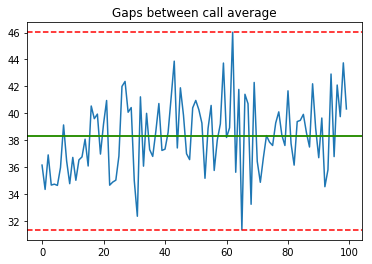

In [28]:
#Gaps analysis 
mean_interval = sum(interval)/len(interval)
print("Mean : {}  Max : {}  Min : {}".format(mean_interval, max(interval), min(interval)))
print("Real data mean : {}".format(mean_inter_HS))

plt.title("Gaps between call average")
plt.plot(interval)
plt.axhline(y=max(interval), color='r', linestyle='--')
plt.axhline(y=min(interval), color='r', linestyle='--')
plt.axhline(y=mean_inter_HS, color='y', linestyle='-')
plt.axhline(y=mean_interval, color='g', linestyle='-')
plt.show()

Mean : 2.787059915164369  Max : 3.026511134676564  Min : 2.559119830328738
Real data mean : 2.769207317073171


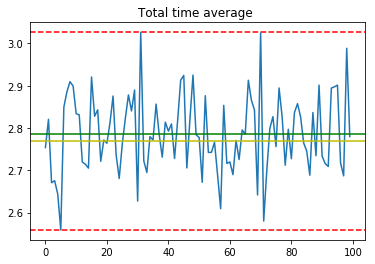

In [29]:
#Time graphs 
print("Mean : {}  Max : {}  Min : {}".format(sum(total_time_mean)/len(total_time_mean), max(total_time_mean), min(total_time_mean)))
print("Real data mean : {}".format(mean_duration_HS))
plt.plot(total_time_mean)
plt.title("Total time average ")
plt.axhline(y=max(total_time_mean), color='r', linestyle='--')
plt.axhline(y=min(total_time_mean), color='r', linestyle='--')
plt.axhline(y=mean_duration_HS, color='y', linestyle='-')
plt.axhline(y=sum(total_time_mean)/len(total_time_mean), color='g', linestyle='-')
plt.show()

AGROVILA             726.0
ARUAU               1763.0
ASS. NAZARE          962.0
BONSUCESSO           502.0
COSTA DO TATU       1506.0
COSTA DOS ARARAS     735.0
CUIEIRAS            2317.0
GUAJARA                0.0
JARAQUI                0.0
LIVRAMENTO          1008.0
MIPINDIAU              0.0
N SRA CARMO         1252.0
N SRA P. SOCORRO     621.0
N. SRA. FATIMA      2040.0
SANTA MARIA         2028.0
Name: Call location, dtype: float64


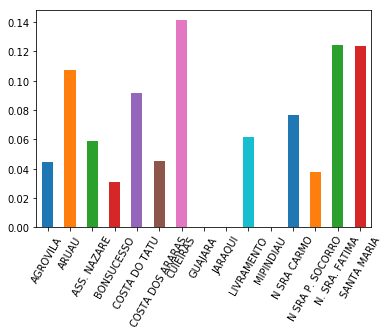

In [30]:
#histogram locations 
for i in [*distance]: 
    if(math.isnan(sum_location[i])): 
        sum_location[i] = 0 
print(sum_location)
result = pd.Series(sum_location/(nb_repet*nb_call))
result.plot(kind='bar', rot=60)


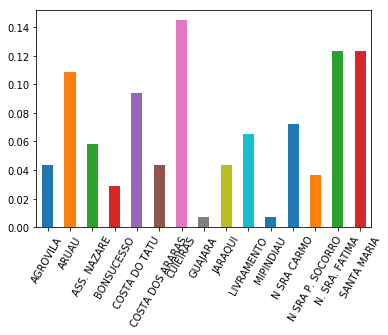

In [31]:
dico = {}
i = 0 
while i != len(p_2015): 
    dico[[*distance][i]] = p_2015[i]
    i = i + 1 
real_data = pd.Series(dico)
real_data.plot(kind='bar', rot=60)

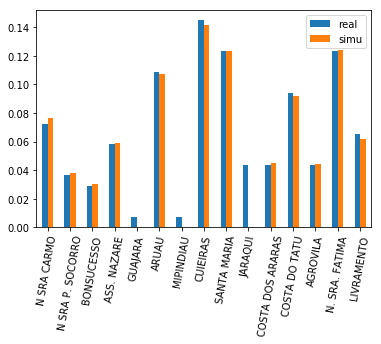

In [32]:
#histogram 
index = []
simul_data = []
for loc in [*distance]: 
    index.append(loc)
    simul_data.append(sum_location[loc]/(nb_repet*nb_call))

result = pd.DataFrame({'real': p_2015, 'simu': simul_data}, index=index)
result.plot.bar(rot=80)